[Reference Email](https://mail.google.com/mail/u/0/?tab=rm&ogbl#inbox/FMfcgzGpGnLZzSmCQPVlgTDcHvhTzksz)

In [3]:
import json
import operator
import random

import pandas as pd
import utils
import numpy as np
import collections


In [4]:
df = pd.read_csv('../data/E_coli_Operon.csv').rename(columns={'Operon': 'operon'})
df

,operon
0,CGCGTACAGGAAACACAGAAAAAAGCCCGCACCTGACAGTGCGGGC...
1,TCACAACTATCGATCAACTCATTCTCATTTTTTGCTAAAGTCGGCA...
2,TCATTCTTAGCGTGACCGGGAAGTCGGTCACGCTACCTCTTCTGAA...
3,CGCCAGAATATAGAAGCCACAAAAA
4,TCGCCCTATAAACGGGTAATTATACTGACACGGGCGAAGGGGAATT...
...,...
666,CTGGAGCATGCTCGGTGATAACCAAAAAT
667,ACCCTGCCGATGCGCAACATCCCGGTTGGTTC
668,ACAAGGAATAACAATTGAAGC
669,TTTTTATGAGGCCGACGATGATTACGGCCTCAGGCGACAGGCACAA...


In [5]:
# select only operons with length lower than 20
df = df.loc[df['operon'].str.len() < 20]
df

,operon
6,TCAGGAGTAAAAGAGCC
11,GGAGAAGATAAGAAA
53,TGGTGAATTATGAAC
64,TTTCTCGGCGCGGTCGT
65,GCGCCTGCTGCCTTT
...,...
651,CCGATAAAATCCGTAC
656,GAAATCGCACGTACCGA
657,TGGCTGGCAGGTGGAG
661,CAACATCATTCACGC


In [6]:
# now generate 100 operons for each operon
# rules: same length, same characters
import random

# random.choices(list(df['operon'].head(1)), k=100)6
import itertools

samples = []


def add_sample(row):
  v = row['operon']
  vs = set()
  while len(vs) != 100:
    vs.add(''.join(random.sample(v, len(v))))

  for s in vs:
    samples.append({'operon_sample': s, 'original_operon': v})


# first time generate
# df.apply(lambda r: add_sample(r), axis=1)
# sdf = pd.DataFrame(samples)

# then load generated results


sdf = pd.read_csv('../data/E_coli_Operon_samples.csv')
sdf

,operon_sample,original_operon
0,AGCGAATACCAAGGATG,TCAGGAGTAAAAGAGCC
1,AGGAACCCAAAAGGTTG,TCAGGAGTAAAAGAGCC
2,CAAACAGTGCAGAAGTG,TCAGGAGTAAAAGAGCC
3,GCAAAAAGTTGGCAACG,TCAGGAGTAAAAGAGCC
4,AGTAAATCAGCGAGGCA,TCAGGAGTAAAAGAGCC
...,...,...
9195,TTGACGAATCGGTTT,TTCTGAAAGGTCGTT
9196,TGTAAGCAGCTTTGT,TTCTGAAAGGTCGTT
9197,ACTGGATTCTTATGG,TTCTGAAAGGTCGTT
9198,GCGTCTTTAAGTGAT,TTCTGAAAGGTCGTT


In [7]:
# now generate the following features on the operons
with open('../data/selected_features.json') as f:
  features_to_generate = [s.strip('group_') for s in json.load(f)]
", ".join(features_to_generate)

'TATG_count, ATTT_count1, ACTT_count1, TCCT_count2, AAGA_count, GA_count, AGA_count1, fold_window_39, cai, CTA_count, shinedal_sliding_12, TTGC_count2, CTT_count, CTAA_count2, ATAA_count, GGAG_count1, GA_count2, CCT_count, TT_count, AGGG_count, shinedal_sliding_11, CT_count2, TATG_count2, shinedal_sliding_20, TCGA_count1, CCAT_count, GCAA_count1'

In [8]:
count_nucs = np.vectorize(utils.count_nucs_sliding)

for frame in [0, 1, 2]:
  for nucs_count in [2, 3, 4]:
    cdf = pd.Series(count_nucs(df.operon, nucs_count=nucs_count, frame=frame, on='operon')).apply(pd.Series).fillna(0)
    df = df.merge(cdf, on='operon', how='left')

    csdf = pd.Series(count_nucs(sdf.operon_sample, nucs_count=nucs_count, frame=frame, on='operon_sample')).apply(
      pd.Series).fillna(0)
    sdf = sdf.merge(csdf, on='operon_sample', how='left')

# we will remove unecessary features later

In [9]:
# we need those as well
set(features_to_generate) - set(df.columns)

{'cai',
 'fold_window_39',
 'shinedal_sliding_11',
 'shinedal_sliding_12',
 'shinedal_sliding_20'}

In [10]:
with open('../data/shinedalgarno.json') as f:
  shinedalgarno_mapping = json.load(f)

shinedalgarno_mapping = {r['seq'].replace('AGGAGG&', ''): r['value'] for r in shinedalgarno_mapping}


def apply_map_shinedalgarno_to_parts(row, name):
  total = 0

  seq = row[name]
  parts = set()
  for i in range(len(seq)):
    if len(p := seq[i:i + 6]) == 6:
      parts.add(p)

  for i, part in enumerate(parts):
    val = shinedalgarno_mapping[part]
    total += val
    row[f'shinedal_sliding_{i}'] = val

  row['shindal_mean'] = total / len(parts)

  return row


df = df.apply(lambda r: apply_map_shinedalgarno_to_parts(r, 'operon'), axis=1).fillna(0)
sdf = sdf.apply(lambda r: apply_map_shinedalgarno_to_parts(r, 'operon_sample'), axis=1).fillna(0)
df

# we will remove unecessary features later

,AAAA_count,AAAA_count1,AAAA_count2,AAAC_count,AAAC_count1,AAAC_count2,AAAG_count,AAAG_count1,AAAG_count2,AAAT_count,...,shinedal_sliding_12,shinedal_sliding_13,shinedal_sliding_2,shinedal_sliding_3,shinedal_sliding_4,shinedal_sliding_5,shinedal_sliding_6,shinedal_sliding_7,shinedal_sliding_8,shinedal_sliding_9
0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,-0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.9,0.0,0.0,0.0,-0.2,-3.5,-3.5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-4.3,-2.7,-3.1,-1.0,-2.3,-2.8,-2.9,-3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-3.3,0.0,0.0,-2.1,-1.7,-3.3,0.0,0.0
88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-1.7,-0.2,-0.2,-1.7,0.0,0.0,-0.5
89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.1,0.0,0.0,0.0,-0.1,0.0,0.0,0.0
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.5,0.0,-0.5,0.0,0.0,0.0,0.0,-0.6


In [11]:
# keep only necessary features
df = df[['operon', *set(features_to_generate).intersection(list(df.columns))]]
sdf = sdf[['operon_sample', 'original_operon', *set(features_to_generate).intersection(list(sdf.columns))]]
df

,operon,TCCT_count2,shinedal_sliding_12,CTT_count,CCAT_count,TCGA_count1,GA_count,GCAA_count1,TATG_count,GGAG_count1,...,ATTT_count1,AGGG_count,TTGC_count2,TATG_count2,shinedal_sliding_11,CTAA_count2,CT_count2,CCT_count,CTA_count,GA_count2
0,TCAGGAGTAAAAGAGCC,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,GGAGAAGATAAGAAA,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,TGGTGAATTATGAAC,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
3,TTTCTCGGCGCGGTCGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.2,0.0,1.0,0.0,0.0,0.0
4,GCGCCTGCTGCCTTT,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,CCGATAAAATCCGTAC,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
88,GAAATCGCACGTACCGA,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.2,0.0,0.0,0.0,0.0,1.0
89,TGGCTGGCAGGTGGAG,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
90,CAACATCATTCACGC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
set(sdf.columns) - set(df.columns)

{'operon_sample', 'original_operon'}

In [13]:
sdf

,operon_sample,original_operon,TCCT_count2,shinedal_sliding_12,CTT_count,CCAT_count,TCGA_count1,GA_count,GCAA_count1,TATG_count,...,ATTT_count1,AGGG_count,TTGC_count2,TATG_count2,shinedal_sliding_11,CTAA_count2,CT_count2,CCT_count,CTA_count,GA_count2
0,AGCGAATACCAAGGATG,TCAGGAGTAAAAGAGCC,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.8,0.0,0.0,0.0,0.0,2.0
1,AGGAACCCAAAAGGTTG,TCAGGAGTAAAAGAGCC,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.8,0.0,0.0,0.0,0.0,1.0
2,CAAACAGTGCAGAAGTG,TCAGGAGTAAAAGAGCC,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,GCAAAAAGTTGGCAACG,TCAGGAGTAAAAGAGCC,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AGTAAATCAGCGAGGCA,TCAGGAGTAAAAGAGCC,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9195,TTGACGAATCGGTTT,TTCTGAAAGGTCGTT,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
9196,TGTAAGCAGCTTTGT,TTCTGAAAGGTCGTT,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9197,ACTGGATTCTTATGG,TTCTGAAAGGTCGTT,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
9198,GCGTCTTTAAGTGAT,TTCTGAAAGGTCGTT,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [14]:
# we need those as well
set(features_to_generate) - set(df.columns)

{'cai', 'fold_window_39', 'shinedal_sliding_20'}

In [15]:
# sdf[['operon_sample', 'original_operon']].to_csv('../data/sequences_for_cai_rngs.csv', index=False)
# df['operon'].to_csv('../data/sequences_for_cai_operons.csv', index=False)

# load response
cdf_operons = pd.read_csv('../data/sequences_for_cai_operons_with_cai.csv')
df = df.merge(cdf_operons, on='operon', how='left').rename(columns={'CAI': 'cai'})

cdf_rngs = pd.read_csv('../data/sequences_for_cai_rngs_with_cai.csv')
sdf = sdf.merge(cdf_rngs[['operon_sample', 'CAI']], on='operon_sample', how='left').rename(columns={'CAI': 'cai'})


In [16]:
# fold_window_39 and shinedal_sliding_20 are irrelevant because they can't be calculated
# on the operons (they require a longer sequence...)
set(features_to_generate) - set(df.columns)

{'fold_window_39', 'shinedal_sliding_20'}

In [17]:
# calculate mean of each feature
features = set(features_to_generate) - {'fold_window_39', 'shinedal_sliding_20'}

for feature in features:
  df[f'mean_{feature}'] = df[feature].mean()

df

,operon,TCCT_count2,shinedal_sliding_12,CTT_count,CCAT_count,TCGA_count1,GA_count,GCAA_count1,TATG_count,GGAG_count1,...,mean_TATG_count,mean_GCAA_count1,mean_GGAG_count1,mean_AGA_count1,mean_ACTT_count1,mean_ATAA_count,mean_CTA_count,mean_TT_count,mean_cai,mean_ATTT_count1
0,TCAGGAGTAAAAGAGCC,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,...,0.054348,0.076087,0.043478,0.206522,0.054348,0.076087,0.086957,1.032609,0.719176,0.054348
1,GGAGAAGATAAGAAA,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.054348,0.076087,0.043478,0.206522,0.054348,0.076087,0.086957,1.032609,0.719176,0.054348
2,TGGTGAATTATGAAC,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,...,0.054348,0.076087,0.043478,0.206522,0.054348,0.076087,0.086957,1.032609,0.719176,0.054348
3,TTTCTCGGCGCGGTCGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.054348,0.076087,0.043478,0.206522,0.054348,0.076087,0.086957,1.032609,0.719176,0.054348
4,GCGCCTGCTGCCTTT,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.054348,0.076087,0.043478,0.206522,0.054348,0.076087,0.086957,1.032609,0.719176,0.054348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,CCGATAAAATCCGTAC,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.054348,0.076087,0.043478,0.206522,0.054348,0.076087,0.086957,1.032609,0.719176,0.054348
88,GAAATCGCACGTACCGA,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.054348,0.076087,0.043478,0.206522,0.054348,0.076087,0.086957,1.032609,0.719176,0.054348
89,TGGCTGGCAGGTGGAG,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.054348,0.076087,0.043478,0.206522,0.054348,0.076087,0.086957,1.032609,0.719176,0.054348
90,CAACATCATTCACGC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.054348,0.076087,0.043478,0.206522,0.054348,0.076087,0.086957,1.032609,0.719176,0.054348


## calculating p value

In [18]:
# each original_operon has 100 operon_samples
# take the first, then second, then third, ... operon_sample from each original_operon and calculate the mean of its features -- call it set_i_feature
# for each feature on each set_i -- check if the set_i_feature is greater than the mean of the feature in the original_operon (df).
# if yes count it

real_avg = df[df.columns[df.columns.str.startswith('mean')]].head(1)  # every col is a feature and there one row
real_avg_d = {k.strip('mean_'): v[0] for k, v in real_avg.to_dict().items()}

feature_rngs_avg_greater = {f: 0 for f in features}

for set_index in range(100):
  set_features = sdf.groupby('original_operon').nth(set_index).reset_index()[list(features)].mean(
    axis=0)  # mean of each feature in set i
  set_features_d = set_features.to_dict()

  for feature in features:
    if feature.startswith('shinedal'):
      if set_features_d[feature] < real_avg_d[feature]:
        feature_rngs_avg_greater[feature] += 1
    else:
      if set_features_d[feature] > real_avg_d[feature]:
        feature_rngs_avg_greater[feature] += 1

feature_rngs_avg_greater = {f: v / 100 for f, v in feature_rngs_avg_greater.items()}
feature_rngs_avg_greater

{'AGGG_count': 0.78,
 'TCCT_count2': 0.91,
 'AAGA_count': 0.14,
 'TTGC_count2': 0.1,
 'shinedal_sliding_12': 0.69,
 'TATG_count2': 0.18,
 'GA_count2': 0.29,
 'CTT_count': 0.72,
 'shinedal_sliding_11': 0.95,
 'CCAT_count': 0.22,
 'TCGA_count1': 0.17,
 'CTAA_count2': 0.85,
 'CT_count2': 0.96,
 'CCT_count': 0.9,
 'GA_count': 0.27,
 'TATG_count': 0.27,
 'GCAA_count1': 0.08,
 'GGAG_count1': 0.53,
 'AGA_count1': 0.73,
 'ACTT_count1': 0.21,
 'ATAA_count': 0.24,
 'CTA_count': 1.0,
 'TT_count': 0.04,
 'cai': 1.0,
 'ATTT_count1': 0.24}

In [19]:
for k, v in feature_rngs_avg_greater.items():
  print("{}: {}".format(k, v))

AGGG_count: 0.78
TCCT_count2: 0.91
AAGA_count: 0.14
TTGC_count2: 0.1
shinedal_sliding_12: 0.69
TATG_count2: 0.18
GA_count2: 0.29
CTT_count: 0.72
shinedal_sliding_11: 0.95
CCAT_count: 0.22
TCGA_count1: 0.17
CTAA_count2: 0.85
CT_count2: 0.96
CCT_count: 0.9
GA_count: 0.27
TATG_count: 0.27
GCAA_count1: 0.08
GGAG_count1: 0.53
AGA_count1: 0.73
ACTT_count1: 0.21
ATAA_count: 0.24
CTA_count: 1.0
TT_count: 0.04
cai: 1.0
ATTT_count1: 0.24


In [20]:
{k:v for k,v in feature_rngs_avg_greater.items() if v < 0.05}

{'TT_count': 0.04}

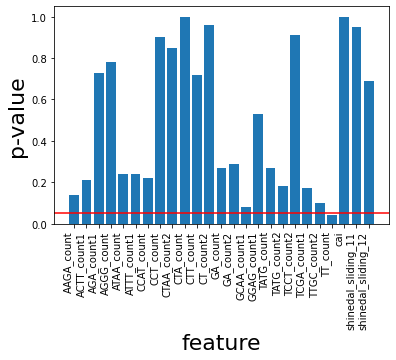

In [21]:
from matplotlib import pyplot as plt

import matplotlib

k, v = zip(*sorted(feature_rngs_avg_greater.items()))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(k, v)
ax.set_ylabel('p-value', fontdict={'fontsize': 22})
ax.set_xlabel('feature', fontdict={'fontsize': 22})
plt.xticks(rotation=90, ha='right')
ax.axhline(y=0.05, color='r', label="0.05")
plt.show()

In [22]:
with open('../data/selected_features_and_appear_count.json') as f:
  features_appear = {k.strip('group_'): v for k, v in json.load(f).items()}

# make sure to remove unrelated features
features_appear = {k: v for k, v in features_appear.items() if k in feature_rngs_avg_greater.keys()}

features_appear

{'TATG_count': 3,
 'ATTT_count1': 1,
 'ACTT_count1': 3,
 'TCCT_count2': 3,
 'AAGA_count': 3,
 'GA_count': 3,
 'AGA_count1': 4,
 'cai': 3,
 'CTA_count': 3,
 'shinedal_sliding_12': 3,
 'TTGC_count2': 3,
 'CTT_count': 1,
 'CTAA_count2': 3,
 'ATAA_count': 2,
 'GGAG_count1': 3,
 'GA_count2': 3,
 'CCT_count': 3,
 'TT_count': 3,
 'AGGG_count': 3,
 'shinedal_sliding_11': 3,
 'CT_count2': 3,
 'TATG_count2': 3,
 'TCGA_count1': 3,
 'CCAT_count': 1,
 'GCAA_count1': 1}

In [23]:
# sort by appear count
#", ".join(str(v) for v in collections.Counter(features_appear).most_common())
vcount = sorted(collections.Counter(features_appear).values(), reverse=True)

In [24]:
# sort by p value
#", ".join(str(v) for v in collections.Counter(feature_rngs_avg_greater).most_common()[::-1])
vpval = sorted(collections.Counter(feature_rngs_avg_greater).values(), reverse=True)

In [25]:
pd.Series(vcount).corr(pd.Series(vpval), method='spearman')

0.7420659703283174